In [1]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [2]:
bag = rosbag.Bag('/home/hakanergin/code/rosbags/static/rotation/21h7/s_yaw_21h7_2m_360_30.bag')

# create variables
target = 'yaw'
true_value = 'true_yaw'

# input values in degrees. the order matters, it will be used for binning 
input_vals = [0,15,30,45,60]

In [3]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t

    # conversion to euler
    rotation_quat = msg.transforms[0].transform.rotation
    pitch, yaw, roll = tf.transformations.euler_from_quaternion([rotation_quat.x,rotation_quat.y,rotation_quat.z,rotation_quat.w], axes='rxyz')

    # all rotations
    # rotation_euler = (np.degrees(pitch), np.degrees(yaw), np.degrees(roll))

    # create row
    row={'time': time.to_sec(), target: np.degrees(yaw)}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [4]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,yaw
0,0.000000,38.657762
1,0.115684,32.484853
2,0.238514,21.098502
3,0.367163,17.324147
4,0.494976,-5.224933
...,...,...
1535,77.570452,69.319925
1536,77.614377,70.314097
1537,77.658369,70.521898
1538,89.172130,71.950248


In [5]:
# drop errors caused by video
df = df.drop(df[df.relative_time < 5].index).reset_index()

<AxesSubplot:xlabel='relative_time'>

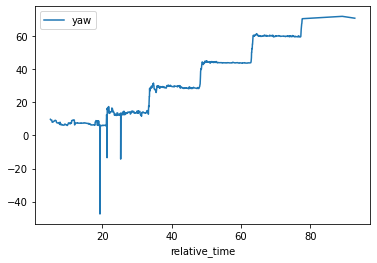

In [6]:
# initial graph
df.plot(x='relative_time', y=target)

In [7]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, .5)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [8]:
# the amount of data points we are left with
len(x[peaks])

282

In [9]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='yaw'>

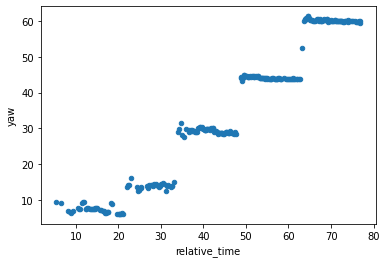

In [10]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [11]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.qcut(df_filtered_by_targets[target], len(input_vals), labels=input_vals, duplicates='drop')

In [12]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [13]:
# remove huge errors because theyre actually wrongly binned
df_filtered_by_targets = df_filtered_by_targets.drop(df_filtered_by_targets[df_filtered_by_targets['error'].abs()>9].index)

In [14]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df_filtered_by_targets)

,index,relative_time,yaw,true_yaw,error
25,64,8.264460,6.848162,0,-6.848162
27,66,8.521593,6.511007,0,-6.511007
30,69,8.912458,6.264244,0,-6.264244
33,72,9.281855,6.853244,0,-6.853244
42,81,10.416054,7.586634,0,-7.586634
45,84,10.784630,7.408051,0,-7.408051
47,86,10.977896,7.533066,0,-7.533066
73,112,12.345042,7.530833,0,-7.530833
76,115,12.479262,7.459718,0,-7.459718
81,120,12.697210,7.602704,0,-7.602704


In [15]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [16]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,index,relative_time,yaw,true_yaw,error
25,64,8.264460,6.848162,0,-6.848162
27,66,8.521593,6.511007,0,-6.511007
288,327,22.311607,14.190451,15,0.809549
291,330,22.452758,14.074473,15,0.925527
549,588,34.174590,29.743404,30,0.256596
558,597,34.701544,31.383111,30,-1.383111
868,907,48.815037,44.354607,45,0.645393
871,910,48.947992,44.074829,45,0.925171
1195,1234,63.682056,60.051135,60,-0.051135
1198,1237,63.813997,60.283272,60,-0.283272


In [17]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_yaw,,,,,,,,
0,37.0,-7.002331,0.670499,-8.878537,-7.533066,-7.256672,-6.371579,-6.025599
15,19.0,0.699632,0.559754,-1.031447,0.447999,0.809549,1.135990,1.234309
30,27.0,0.120909,0.415927,-1.383111,-0.101386,0.220173,0.438621,0.650308
45,39.0,0.496816,1.358175,-7.584041,0.441666,0.671164,0.997010,1.050725
60,57.0,-0.254555,0.304357,-1.326024,-0.308240,-0.161218,-0.055385,0.051459


In [18]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

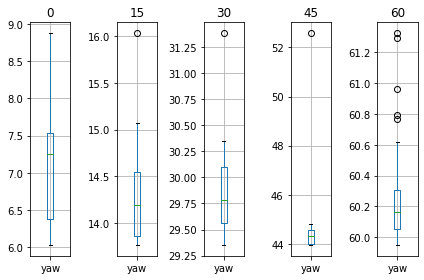

In [19]:
box_plotter(target)

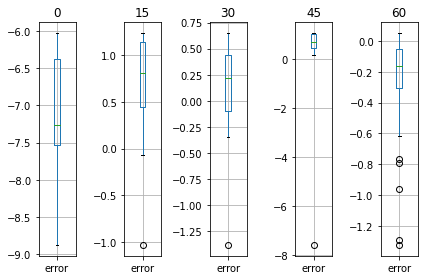

In [20]:
box_plotter('error')

In [21]:
df_filtered_by_targets.to_csv('/home/hakanergin/code/apriltag_test_bench/test_pipeline/scripts/static_tests/rotations/result/csv/2m_21h7_360.csv')